# Extract Label Studio images with their annotations

## Import packages

In [1]:
import boto3
import os
import json
import cv2
import numpy as np
import requests
import yaml
import matplotlib.pyplot as plt

## Get environement variables and define others

In [2]:
AWS_ACCESS_KEY_ID = os.environ.get("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.environ.get("AWS_SECRET_ACCESS_KEY")
AWS_S3_BUCKET = os.environ.get("AWS_S3_BUCKET")
AWS_S3_ENDPOINT = os.environ.get("AWS_S3_ENDPOINT")

DATASET_PATH = "dataset/"
DATA_CONFIG_PATH = "utils/data.yaml"
LOCAL_LABEL_FOLDER = "/tmp/labels/"
TARGET_BUCKET = "label-studio-sink"
LABEL_STUDIO_SVC = "http://label-studio-ls-app.label-studio.svc.cluster.local"

## Define object storage client

In [3]:
session = boto3.Session(
    aws_access_key_id=AWS_ACCESS_KEY_ID,
    aws_secret_access_key=AWS_SECRET_ACCESS_KEY
)
client = session.client("s3", endpoint_url=AWS_S3_ENDPOINT)

## Define useful functions

In [4]:
def generate_dirs():
    os.makedirs(DATASET_PATH, exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "labels/val", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/train", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/test", exist_ok = True)
    os.makedirs(DATASET_PATH + "images/val", exist_ok = True)
    os.makedirs(LOCAL_LABEL_FOLDER, exist_ok=True)

In [5]:
def download_folder(bucket_name):
    paginator = client.get_paginator('list_objects_v2')
    operation_parameters = {'Bucket': bucket_name}
    page_iterator = paginator.paginate(**operation_parameters)
    for page in page_iterator:
        if 'Contents' in page:
            for obj in page['Contents']:
                key = obj['Key']
                client.download_file(bucket_name, key, LOCAL_LABEL_FOLDER + key.split("/")[-1])

In [6]:
def xyxy_to_yolo(bbox, image_width, image_height):
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    # Normalize coordinates by image width and height
    x_center /= image_width
    y_center /= image_height
    width /= image_width
    height /= image_height
    return x_center, y_center, width, height

In [7]:
def ls_to_xyxy(bbox, img_w, img_h):
    x, y, w, h = bbox
    x1 = int(x * img_w)
    y1 = int(y * img_h)
    x2 = int(x1 + w * img_w)
    y2 = int(y1 + h * img_h)
    return x1, y1, x2, y2

In [8]:
def show_image(image_path, label_path):
    image = cv2.imread(image_path)
    with open(label_path, 'r') as handler:
        while True:
            line = handler.readline()
            if not line:
                break
            line = line.split(" ")
            label = int(line[0])
            x, y, w, h = (float(e) for e in line[1:])
            bbox = (float(x), float(y), float(w), float(h))
            img_h, img_w, _ = image.shape
            x1, y1, x2, y2 = x - (w / 2), y - (h / 2), x + (w / 2), y + (h / 2)
            x1, y1, x2, y2 = int(x1 * img_w), int(y1 * img_h), int(x2 * img_w), int(y2 * img_h)
            color = (0,0,255) if label == 1 else (255,0,0)
            image = cv2.rectangle(image, (x1, y1), (x2, y2), color=color, thickness=2)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        handler.close()

In [9]:
def add_image_to_dataset(split, uri, annotations):
    image_remote_path = LABEL_STUDIO_SVC + uri
    image_name = image_remote_path.split("/")[-1]
    image_path = DATASET_PATH + "images/" + split + "/" + image_name
    label_file_name = ".".join(image_name.split(".")[:-1]) + ".txt"
    label_path = DATASET_PATH + "labels/" + split + "/" + label_file_name
    img_data = requests.get(uri).content
    with open(image_path, 'wb') as handler:
        handler.write(img_data)
    image = cv2.imread(image_path)
    img_h, img_w, _ = image.shape
    with open(DATA_CONFIG_PATH, 'r') as f:
        data_config = yaml.safe_load(f)
    label_line = ""
    for ann in annotations:
        bbox_xyxy = ls_to_xyxy(ann[1], img_w, img_h)
        x, y, w, h = xyxy_to_yolo(bbox_xyxy, img_w, img_h)
        label_name = ann[0]
        label_id = list(data_config["names"].keys())[list(data_config["names"].values()).index(label_name)]
        label_line += f"{label_id} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n"
    with open(label_path, 'w') as f:
        f.write(label_line)

In [10]:
def determine_split(i, nb_data):
    if nb_data < 5:
        split = "train"
    else:
        split = "train" if i / nb_data <= 0.9 else "val"
    return split

## Iterate over images and extract their annotation

In [11]:
generate_dirs()
download_folder(TARGET_BUCKET)
files = [LOCAL_LABEL_FOLDER + label for label in os.listdir(LOCAL_LABEL_FOLDER)]
nb_data = len(files)
for i, file in enumerate(files):
    split = determine_split(i, nb_data)
    with open(file) as f:
        payload = json.load(f)
    image_uri = payload['task']['data']['image']
    annotations = [(ann['value']['rectanglelabels'][0], (ann['value']['x'] / 100, ann['value']['y'] / 100, ann['value']['width'] / 100, ann['value']['height'] / 100)) for ann in payload['result']]
    add_image_to_dataset(split, image_uri, annotations)

## Select a random image and display its boundind boxes

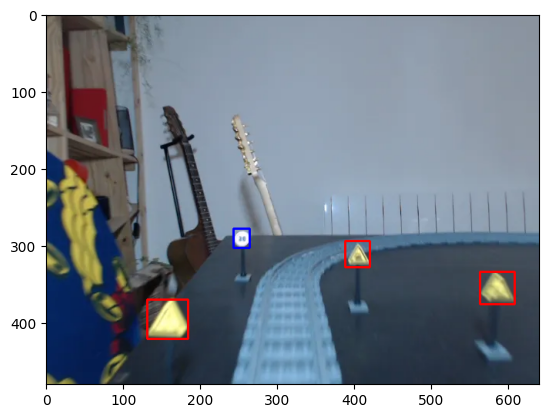

In [12]:
import random
file = random.choice(os.listdir("dataset/images/train")).split(".jpg")[0]
label_path = "dataset/labels/train/"+file+".txt"
image_path = "dataset/images/train/"+file+".jpg"
show_image(image_path, label_path)

In [13]:
! tar -czf dataset.tar.gz dataset